# Pipeline
in this file we build a pipeline to 
- load (local) fmnist csv dataset
- preprocess 
    - normalize 
    - convert to np 
- and train an AE (simple conv, some casual architechture). 

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline 


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data

import csv as data frame (pandas) and convert to nparray

In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')


separate labels
X_train.pop pops specific features (original feature is deleted in X_train)

In [3]:
labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

create sklearn pipeline for normalizing

In [4]:
#normalize = Pipeline(steps = ['minmax_normalize', MinMaxScaler()]) # choose transform

In [5]:
normalize = MinMaxScaler() # choose transform
normalize.fit(df_train); # fit transform
df_train_normalized = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
df_test_normalized = np.single(normalize.transform(df_test))

reshape from vector to img

In [6]:
X_train = df_train_normalized.reshape(-1,28,28)
X_test = df_test_normalized.reshape(-1,28,28)

## build AE
design AE as specific architecture 
    right now: simple layer


In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [22]:
input_img = Input(shape=(28,28,1))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', 
                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
encoded = Flatten()(encoded)
#encoded = Dense(196, activation='relu')(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=(196,))
encoder.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 4)           292 

In [23]:
# model: decoder
#decoded = Dense(392, activation='relu')(input_encoded)
decoded = Reshape((7,7,4))(input_encoded)
decoded = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(32, (3, 3), activation='relu', 
                                padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 8)           296       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 7, 7, 16)          1168      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 32)        4640      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 32)        0   

In [24]:
# model: autoencoder (encoder + decoder)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)

loss = tf.keras.losses.BinaryCrossentropy();
autoencoder.compile(optimizer=optimizer, loss=loss)

#autoencoder.summary()

## train AE

In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0003)
ckpt_filepath = 'model/fmnist_ae/checkpoints/fmnist_ae-ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping],
                verbose=1)

Epoch 1/50
235/235 [==============================] - 4s 14ms/step - loss: 0.4022 - val_loss: 0.2904
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2894 - val_loss: 0.2807
Epoch 3/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2820 - val_loss: 0.2769
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2775 - val_loss: 0.2739
Epoch 5/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2749 - val_loss: 0.2727
Epoch 6/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2737 - val_loss: 0.2716
Epoch 7/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2725 - val_loss: 0.2704
Epoch 8/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2712 - val_loss: 0.2685
Epoch 9/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2699 - val_loss: 0.2673
Epoch 10/50
235/235 [==============================] - 3s 12ms/step - loss: 0.2696 - val_lo

In [26]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

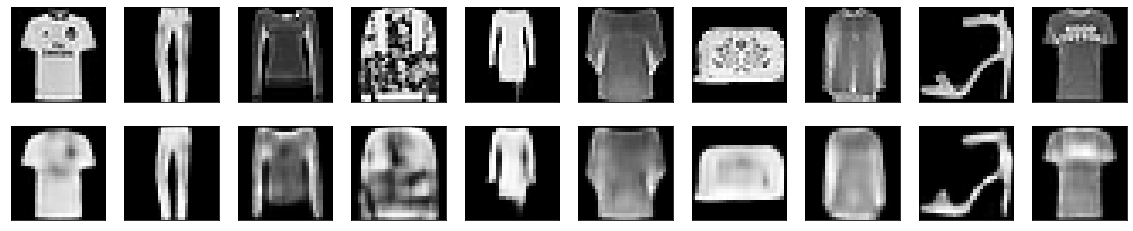

In [27]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels/categories


In [ ]:
#df_decoded_imgs = pd.DataFrame(data=decoded_imgs.reshape(-1,784))
#df_decoded_imgs = df_decoded_imgs.join(labels_test)
#df_decoded_imgs

filter by categories

In [ ]:
#for i in range(10): # it should be better this way if each category has the same number of items

In [64]:
decoded_imgs_0 = decoded_imgs[labels_test==0]
decoded_imgs_1 = decoded_imgs[labels_test==1]
decoded_imgs_2 = decoded_imgs[labels_test==2]
decoded_imgs_3 = decoded_imgs[labels_test==3]
decoded_imgs_4 = decoded_imgs[labels_test==4]

decoded_imgs_5 = decoded_imgs[labels_test==5]
decoded_imgs_6 = decoded_imgs[labels_test==6]
decoded_imgs_7 = decoded_imgs[labels_test==7]
decoded_imgs_8 = decoded_imgs[labels_test==8]
decoded_imgs_9 = decoded_imgs[labels_test==9]



In [65]:
original_imgs_0 = X_test[labels_test==0]
original_imgs_1 = X_test[labels_test==1]
original_imgs_2 = X_test[labels_test==2]
original_imgs_3 = X_test[labels_test==3]
original_imgs_4 = X_test[labels_test==4]

original_imgs_5 = X_test[labels_test==5]
original_imgs_6 = X_test[labels_test==6]
original_imgs_7 = X_test[labels_test==7]
original_imgs_8 = X_test[labels_test==8]
original_imgs_9 = X_test[labels_test==9]


## show by labels/categories

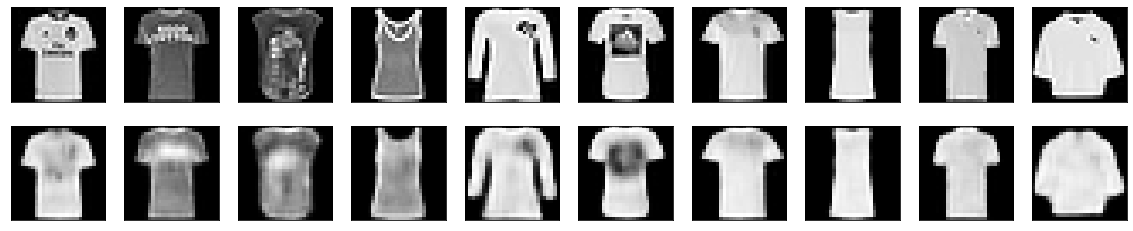

In [66]:

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(original_imgs_0[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_0[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## calculate loss for each category

In [67]:
loss_test = np.ndarray(10)

In [68]:

loss_test[0] = loss(original_imgs_0.reshape(-1,784),decoded_imgs_0.reshape(-1,784)).numpy()
loss_test[1] = loss(original_imgs_1.reshape(-1,784),decoded_imgs_1.reshape(-1,784)).numpy()
loss_test[2] = loss(original_imgs_2.reshape(-1,784),decoded_imgs_2.reshape(-1,784)).numpy()
loss_test[3] = loss(original_imgs_3.reshape(-1,784),decoded_imgs_3.reshape(-1,784)).numpy()
loss_test[4] = loss(original_imgs_4.reshape(-1,784),decoded_imgs_4.reshape(-1,784)).numpy()

loss_test[5] = loss(original_imgs_5.reshape(-1,784),decoded_imgs_5.reshape(-1,784)).numpy()
loss_test[6] = loss(original_imgs_6.reshape(-1,784),decoded_imgs_6.reshape(-1,784)).numpy()
loss_test[7] = loss(original_imgs_7.reshape(-1,784),decoded_imgs_7.reshape(-1,784)).numpy()
loss_test[8] = loss(original_imgs_8.reshape(-1,784),decoded_imgs_8.reshape(-1,784)).numpy()
loss_test[9] = loss(original_imgs_9.reshape(-1,784),decoded_imgs_9.reshape(-1,784)).numpy()

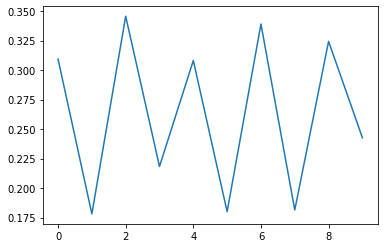

In [69]:
plt.plot(range(10),loss_test)

## t-SNE visualization

In [70]:
encoded_imgs.shape

(10000, 196)

In [28]:
from sklearn.manifold import TSNE

latent_manifold = TSNE(n_components=3, random_state=33)
latent_points = latent_manifold.fit_transform(encoded_imgs) # doesn't work for 7,7,4 only works with 7,7,<=2

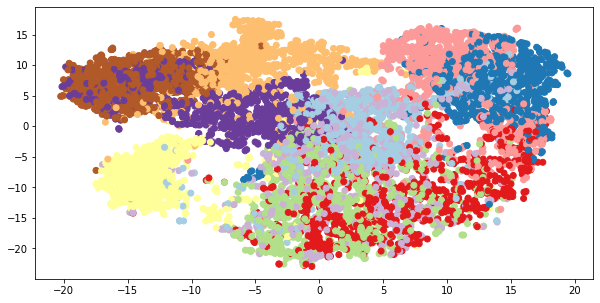

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(latent_points[:, 0], 
    latent_points[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/fmnist_ae/fmnist_tsne.png', dpi=120)
plt.show()

## UMAP visualization

In [30]:
import umap
import umap.plot

In [31]:
mapper = umap.UMAP().fit(encoded_imgs)

<AxesSubplot:>

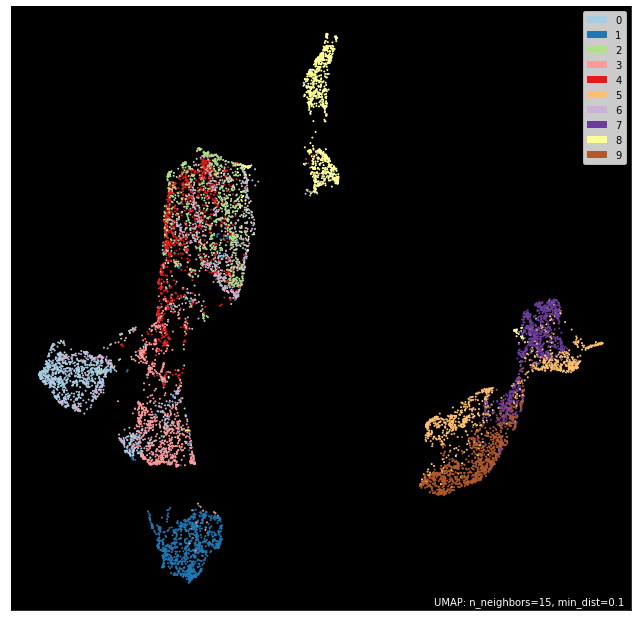

In [32]:
umap.plot.points(mapper, labels=labels_test, color_key_cmap='Paired', background='black')

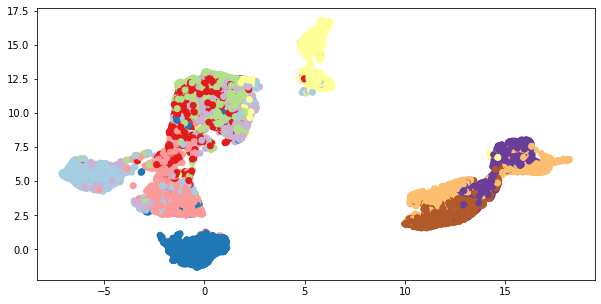

In [33]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/fmnist_ae/fmnist_umap.png', dpi=120)
plt.show()